In [2]:
import torch
def get_positions(doc, e1, e2, tokenizer, debug=False, add_spacing=False):
    spans = []
    tmp_final_output = torch.LongTensor([tokenizer.bos_token_id])
    event_list = [e1, e2]
    context = ""
    if e1.sent_id != e2.sent_id:
        # ==================== DIFFERENT SENTENCE =====================================
        if debug:
            print('DIFF!')

        for id_ev, ev in enumerate(event_list):
            sentence = doc.text[ev.sent_id]
            if ev.offset.start > 0:
                if (id_ev > 0) and add_spacing:
                    # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                    # Not for lama
                    pre_event = tokenizer(
                        " " + " ".join(sentence[0 : ev.offset.start]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                else:
                    pre_event = tokenizer(
                        " ".join(sentence[0 : ev.offset.start]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
            else:
                pre_event = torch.Tensor([])
            if (
                " ".join(sentence[0 : ev.offset.start]) != " "
                and add_spacing
            ):
                # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                event = tokenizer(
                    " " + "[event1]"+ " " + " ".join(sentence[ev.offset])+ " " + "[event2/]" + " ",
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            else:
                event = tokenizer(
                    " " + "[event1]"+ " " + " ".join(sentence[ev.offset])+ " " + "[event2/]" + " ",
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
            if ev.offset.stop < len(sentence):
                if add_spacing:
                    post_event = tokenizer(
                        " " + " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]

                else:
                    post_event = tokenizer(
                        " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                # print(final_output.size(), len(final_output), " ".join(doc.text[ev.sent_id][0:ev.offset]))
            else:
                post_event = torch.tensor([])
            tmp_final_output = torch.cat([tmp_final_output, pre_event], dim=0).type(
                torch.LongTensor
            )
            s = len(tmp_final_output)
            tmp_final_output = torch.cat([tmp_final_output, event], dim=0).type(
                torch.LongTensor
            )
            e = len(tmp_final_output)  # - 1 # We remove the extra space we added
            tmp_final_output = torch.cat([tmp_final_output, post_event], dim=0).type(
                torch.LongTensor
            )
            context += " ".join(sentence).strip() + " "
            # print(s,e)
            spans.append((s, e))
            if debug:
                print("In LOOP:", tokenizer.convert_ids_to_tokens(tmp_final_output), tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", ""), (s, e), ev.token)
                print("Decoded:", tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", "") == ev.token)
            assert tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", "") ==  "[event1]" + ev.token.strip().replace(" ", "") +  "[event2/]"

    else:
        # ==================== SAME SENTENCE =====================================
        if debug:
            print('SAME!')
        # print(sentence, e1.token, e2.token)
        start = 0
        sentence = doc.text[e1.sent_id]
        context += " ".join(sentence).strip()
        for id_ev, ev in enumerate(event_list):
            if (
                (id_ev > 0)
                and " ".join(sentence[start : ev.offset.start]).strip() != ""
                and add_spacing
            ):
                # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                pre_event = tokenizer(
                    " " + " ".join(sentence[start : ev.offset.start]).strip(),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            else:
                pre_event = tokenizer(
                    " ".join(sentence[start : ev.offset.start]),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            if (
                " ".join(sentence[start : ev.offset.start]) != "" or id_ev > 0
            ) and add_spacing:
                # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                event = tokenizer(
                    " " + "[event1]"+ " " + " ".join(sentence[ev.offset])+ " " + "[event2/]" + " ",
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            else:
                event = tokenizer(
                    " " + "[event1]" + " " + " ".join(sentence[ev.offset])+ " " + "[event2/]" + " ",
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
                
            start = ev.offset.start + 1
            tmp_final_output = torch.cat([tmp_final_output, pre_event], dim=0).type(
                torch.LongTensor
            )
            s = len(tmp_final_output)
            tmp_final_output = torch.cat([tmp_final_output, event], dim=0).type(
                torch.LongTensor
            )
            e = len(tmp_final_output)  # - 1 # We remove the extra space we added
            if id_ev + 1 == len(event_list):
                if " ".join(sentence[ev.offset.stop :]) != "" and add_spacing:
                    # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                    post_event = tokenizer(
                        " " + " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                else:
                    post_event = tokenizer(
                        " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                tmp_final_output = torch.cat([tmp_final_output, post_event], dim=0).type(
                torch.LongTensor
            )
            if debug:
                print(tmp_final_output)
                print('LOOP:', tokenizer.convert_ids_to_tokens(tmp_final_output), (s, e), ev.token)
                print('LOOP:', tokenizer.convert_ids_to_tokens(tmp_final_output))
                print('LOOP:', tokenizer.decode(tmp_final_output[s:e]), (s, e), ev.token)
            assert tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", "") == "[event1]" + ev.token.strip().replace(" ", "") + "[event2/]"
            spans.append((s, e))

    context = context.strip()
    if  add_spacing:
        final_output = tokenizer(context, padding=False, return_tensors="pt")[
            "input_ids"
        ][0]
    else:
        eos = torch.LongTensor([tokenizer.eos_token_id])
        final_output = torch.cat([tmp_final_output, eos], dim=0)

    for id_s, span in enumerate(spans):
        ev = event_list[id_s]
        if (
            tokenizer.decode(final_output[span[0] : span[1]]).strip().replace(" ", "")
            != ev.token.strip().replace(" ", "")
        ):
            tokens = tokenizer.convert_ids_to_tokens(final_output)
            tmp_tokens = tokenizer.convert_ids_to_tokens(tmp_final_output)
            for id_x, x in enumerate(tmp_tokens):
                if x != tokens[id_x]:
                    print(x, tokens[id_x], id_x)
                    break
                
    return spans, tokenizer.convert_ids_to_tokens(final_output)

def get_positions_BERT(doc, e1, e2, tokenizer, debug=False, add_spacing=True):
    spans = []
    tmp_final_output = torch.LongTensor([tokenizer.bos_token_id])
    event_list = [e1, e2]
    context = ""
    if e1.sent_id != e2.sent_id:
        # ==================== DIFFERENT SENTENCE =====================================
        if debug:
            print('DIFF!')

        for id_ev, ev in enumerate(event_list):
            sentence = doc.text[ev.sent_id]
            if ev.offset.start > 0:
                if (id_ev > 0) and add_spacing:
                    # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                    # Not for lama
                    pre_event = tokenizer(
                        " " + " ".join(sentence[0 : ev.offset.start]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                else:
                    pre_event = tokenizer(
                        " ".join(sentence[0 : ev.offset.start]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
            else:
                pre_event = torch.Tensor([])
            if (
                " ".join(sentence[0 : ev.offset.start]) != " "
                and add_spacing
            ):
                # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                event = tokenizer(
                    " " +  " ".join(sentence[ev.offset]),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            else:
                event = tokenizer(
                    " ".join(sentence[ev.offset]),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
            if ev.offset.stop < len(sentence):
                if add_spacing:
                    post_event = tokenizer(
                        " " + " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]

                else:
                    post_event = tokenizer(
                        " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                # print(final_output.size(), len(final_output), " ".join(doc.text[ev.sent_id][0:ev.offset]))
            else:
                post_event = torch.tensor([])
            tmp_final_output = torch.cat([tmp_final_output, pre_event], dim=0).type(
                torch.LongTensor
            )
            s = len(tmp_final_output)
            tmp_final_output = torch.cat([tmp_final_output, event], dim=0).type(
                torch.LongTensor
            )
            e = len(tmp_final_output)  # - 1 # We remove the extra space we added
            tmp_final_output = torch.cat([tmp_final_output, post_event], dim=0).type(
                torch.LongTensor
            )
            context += " ".join(sentence).strip() + " "
            # print(s,e)
            spans.append((s, e))
            if debug:
                print("In LOOP:", tokenizer.convert_ids_to_tokens(tmp_final_output), tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", ""), (s, e), ev.token)
                print("Decoded:", tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", "") == ev.token)
            assert tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", "") ==   ev.token.strip().replace(" ", "")

    else:
        # ==================== SAME SENTENCE =====================================
        if debug:
            print('SAME!')
        # print(sentence, e1.token, e2.token)
        start = 0
        sentence = doc.text[e1.sent_id]
        context += " ".join(sentence).strip()
        for id_ev, ev in enumerate(event_list):
            if (
                (id_ev > 0)
                and " ".join(sentence[start : ev.offset.start]).strip() != ""
                and add_spacing
            ):
                # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                pre_event = tokenizer(
                    " " + " ".join(sentence[start : ev.offset.start]).strip(),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            else:
                pre_event = tokenizer(
                    " ".join(sentence[start : ev.offset.start]),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            if (
                " ".join(sentence[start : ev.offset.start]) != "" or id_ev > 0
            ) and add_spacing:
                # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                event = tokenizer(
                    " " + " ".join(sentence[ev.offset]),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
            else:
                event = tokenizer(
                    " ".join(sentence[ev.offset]),
                    padding=False,
                    return_tensors="pt",
                    add_special_tokens=False,
                )["input_ids"][0]
                
            start = ev.offset.start + 1
            tmp_final_output = torch.cat([tmp_final_output, pre_event], dim=0).type(
                torch.LongTensor
            )
            s = len(tmp_final_output)
            tmp_final_output = torch.cat([tmp_final_output, event], dim=0).type(
                torch.LongTensor
            )
            e = len(tmp_final_output)  # - 1 # We remove the extra space we added
            if id_ev + 1 == len(event_list):
                if " ".join(sentence[ev.offset.stop :]) != "" and add_spacing:
                    # Here we add a space because for the tokenizer Ġsaid e said are different where Ġ is a whitespace
                    post_event = tokenizer(
                        " " + " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                else:
                    post_event = tokenizer(
                        " ".join(sentence[ev.offset.stop :]),
                        padding=False,
                        return_tensors="pt",
                        add_special_tokens=False,
                    )["input_ids"][0]
                tmp_final_output = torch.cat([tmp_final_output, post_event], dim=0).type(
                torch.LongTensor
            )
            if debug:
                print(tmp_final_output)
                print('LOOP:', tokenizer.convert_ids_to_tokens(tmp_final_output), (s, e), ev.token)
                print('LOOP:', tokenizer.convert_ids_to_tokens(tmp_final_output))
                print('LOOP:', tokenizer.decode(tmp_final_output[s:e]), (s, e), ev.token)
            assert tokenizer.decode(tmp_final_output[s:e]).strip().replace(" ", "") == ev.token.strip().replace(" ", "")
            spans.append((s, e))

    context = context.strip()
    if  add_spacing:
        final_output = tokenizer(context, padding=False, return_tensors="pt")[
            "input_ids"
        ][0]
    else:
        eos = torch.LongTensor([tokenizer.eos_token_id])
        final_output = torch.cat([tmp_final_output, eos], dim=0)

    for id_s, span in enumerate(spans):
        ev = event_list[id_s]
        if (
            tokenizer.decode(final_output[span[0] : span[1]]).strip().replace(" ", "")
            != ev.token.strip().replace(" ", "")
        ):
            tokens = tokenizer.convert_ids_to_tokens(final_output)
            tmp_tokens = tokenizer.convert_ids_to_tokens(tmp_final_output)
            for id_x, x in enumerate(tmp_tokens):
                if x != tokens[id_x]:
                    print(x, tokens[id_x], id_x)
                    break

            print(
                tokenizer.convert_ids_to_tokens(final_output),
                span,'Event:',
                ev.token,
                "DEC:",
                tokenizer.convert_ids_to_tokens(
                    final_output[span[0] : span[1]]
                ),
            )
        assert (
            tokenizer.decode(final_output[span[0] : span[1]]).strip().replace(" ", "") == ev.token.strip().replace(" ", "")
        )
    return spans, tokenizer.convert_ids_to_tokens(final_output)

def get_top_k_positions(attibutes, top_k, norm=False):
    ordered = sorted(attibutes, reverse=True)[0:top_k]
    if norm:
        return [round(attibutes.index(x)/len(attibutes),4) for x in ordered]
    else:
        return [attibutes.index(x) for x in ordered]

data/MATRES/test.pkl
data/TIMELINE/test.pkl
data/TB-DENSE/test.pkl
{'good': [0.99, 0.72, 0.73, 0.96, 0.63, 0.24, 0.88, 0.21, 0.96, 0.06, 0.5, 0.11, 0.43, 0.02, 0.46, 0.96, 0.99, 0.73, 0.89, 0.94, 0.49, 0.25, 0.89, 0.89, 0.41, 0.99, 0.77, 0.48, 0.84, 0.42, 0.29, 0.99, 0.84, 0.64, 0.15, 0.99, 0.47, 0.94, 0.07, 0.52, 0.99, 0.41, 0.3, 0.43, 0.6, 0.78, 0.46, 0.35, 0.94, 0.18, 0.54, 0.48, 0.11, 0.19, 0.99, 0.87, 0.58, 0.16, 0.7, 0.9, 0.92, 0.4, 0.78, 0.0, 0.74, 0.99, 0.69, 0.63, 0.43, 0.52, 0.5, 0.29, 0.3, 0.99, 0.48, 0.99, 0.63, 0.94, 0.47, 0.57, 0.98, 0.24, 0.5, 0.05, 0.67, 0.6, 0.18, 0.67, 0.24, 0.37, 0.06, 0.8, 0.99, 0.23, 0.34, 0.63, 0.65, 0.99, 0.64, 0.54, 0.77, 0.74, 0.69, 0.46, 0.55, 0.62, 0.9, 0.38, 0.73, 0.09, 0.53, 0.2, 0.24, 0.94, 0.99, 0.4, 0.09, 0.96, 0.12, 0.62, 0.58, 0.28, 0.75, 0.44, 0.39, 0.99, 0.95, 0.5, 0.6, 0.04, 0.47, 0.15, 0.99, 0.2, 0.57, 0.18, 0.5, 0.99, 0.6, 0.55, 0.06, 0.67, 0.82, 0.62, 0.93, 0.45, 0.52, 0.47, 0.29, 0.26, 0.14, 0.61, 0.25, 0.49, 0.62, 0.99, 0.24, 1

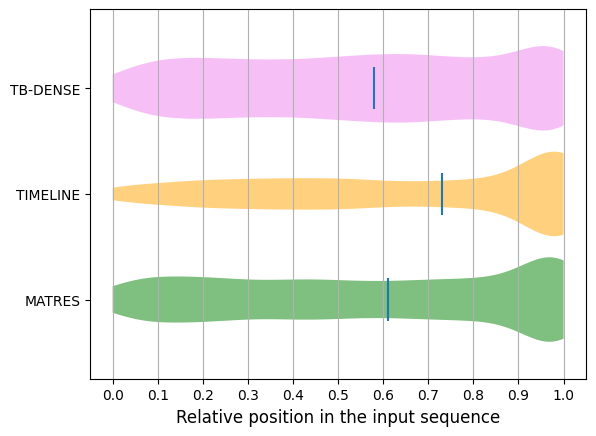

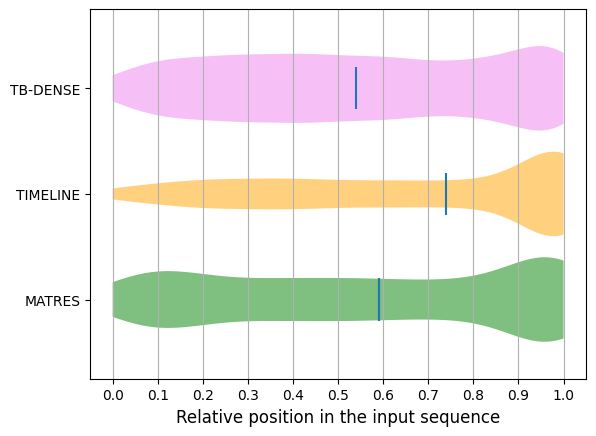

In [8]:
import pickle
import numpy as np 
from transformers import AutoTokenizer
import os 
import torch
from collections import Counter
import matplotlib.pyplot as plt


datasets = ["MATRES", "TIMELINE", "TB-DENSE"]
offsets = [261, 262, 460]
event_spans = {}
final_output = {}

all_class = {}
positions = {}
tokens = {}
positions_ev1 = {}
positions_ev2 = {}
for idd, dataset_name in enumerate(datasets):
    prompt = "_kernelShap.pkl"
    data = []
    with open(dataset_name+prompt, "rb") as f:
        data = pickle.load(f)
        
    data_base_path = f"data/{dataset_name}"
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

    splits = {}
    for file in os.listdir(data_base_path):
        root_name = file.split(".")[0]
        if root_name in ["test"]:
            print(os.path.join(data_base_path, file))
            with open(os.path.join(data_base_path, file), "rb") as reader:
                splits[root_name] = pickle.load(reader)
                
    event_spans[dataset_name] = []
    final_output[dataset_name] = []

    for doc in splits['test']:
        d_id = doc.d_id
        for rel_type, rels in doc.temporal_relations.items():
            for rel in rels:
                if rel_type != "VAGUE":
                    span, fo = get_positions(doc, rel.event1, rel.event2, tokenizer, add_spacing=False)
                    event_spans[dataset_name].append(span)
                    final_output[dataset_name].append(fo)
    all_class[dataset_name] = {}
    positions[dataset_name] = {}
    tokens[dataset_name] = {}
    positions_ev1[dataset_name] = {}
    positions_ev2[dataset_name] = {}
    
    for k, d in data.items():
        all_class[dataset_name][k] = []
        positions[dataset_name][k] = []
        tokens[dataset_name][k] = []
        positions_ev1[dataset_name][k] = []
        positions_ev2[dataset_name][k] = []
        

        offset = offsets[idd]

        for id_el, el in enumerate(d):
            if el != None:
                pos = get_top_k_positions(el.seq_attr.cpu().numpy().tolist(), 5)
                classes = ["to_predict" if x >= offset else "few_shot" for x in pos]
                tokens[dataset_name][k].extend([el.input_tokens[x] for x in pos])
                seq_len = el.seq_attr.size()[0] - offset - 1 
                if "to_predict" in classes:
                    positions_ev1[dataset_name][k].append(round((event_spans[dataset_name][id_el][0][0])/seq_len, 2))
                    positions_ev2[dataset_name][k].append(round((event_spans[dataset_name][id_el][1][0])/seq_len, 2))
                for id_k, cls in enumerate(classes):
                    if cls == "to_predict" :
                        positions[dataset_name][k].append(round((pos[id_k]-offset)/seq_len, 2))
                all_class[dataset_name][k].extend(classes)


def set_axis_style(ax, labels):
    ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_ylim(0.25, len(labels) + 0.75)
    # ax.set_ylabel('Datasets')
  
for k in data.keys():
    pos = 0
    distr = []
    for d_name, data_d in positions.items():
        if len(data_d[k]) > 0:
             distr.append(data_d[k])

    if len(distr) == len(positions):
        fig, ax = plt.subplots()
        parts = ax.violinplot(distr, vert=False, positions=[1,2, 3], widths=0.8, showmeans=False, showextrema=False, showmedians=True, points=500)
        colors = ['Green', 'Orange', 'Violet']
        # Set the color of the violin patches
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.5)
        ticks_x = np.arange(0, 1.1, 0.1)

        ax.set_xticks(ticks_x)
        title = 'token_positions_of_' + k + "_" + dataset_name+prompt
        plt.xlabel('Relative position in the input sequence', fontsize='12')
        labels = list(positions.keys())
        plt.grid(axis='x')
        set_axis_style(ax, labels)
        plt.savefig("img/" + title + ".pdf", transparent=True, dpi=300, format="pdf")
        plt.show()


data/MATRES/test.pkl
data/TIMELINE/test.pkl
data/TB-DENSE/test.pkl


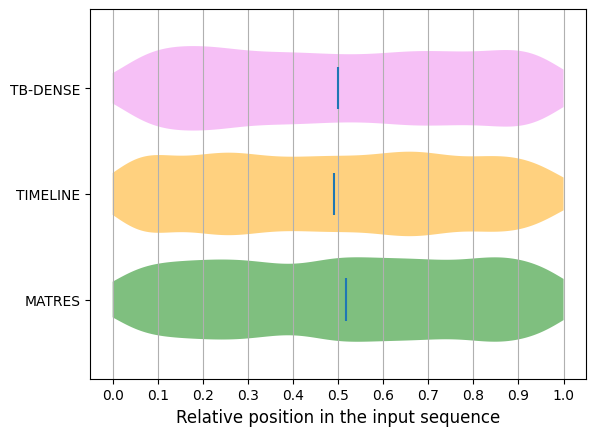

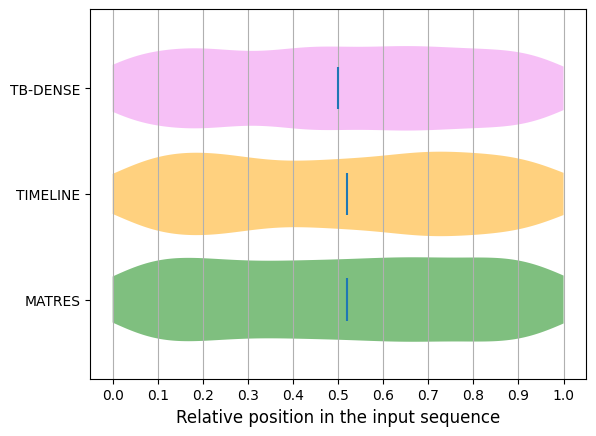

In [4]:
import pickle
import numpy as np 
from transformers import AutoTokenizer, RobertaTokenizerFast
import os 
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


from dataclasses import dataclass
@dataclass
class BertAttribute:
    seq_attr: torch.Tensor
    input_tokens: torch.Tensor
    
datasets = ["MATRES", "TIMELINE", "TB-DENSE"]
offsets = [261, 262, 460]
event_spans = {}
final_output = {}

all_class = {}
positions = {}
tokens = {}
positions_ev1 = {}
positions_ev2 = {}
for idd, dataset_name in enumerate(datasets):

    prompt =  "_kernelShap_RoBERTa.pkl"
    with open(dataset_name + prompt, "rb") as f:
        data = pickle.load(f)

    data_base_path = f"data/{dataset_name}"
    tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

    
    splits = {}
    for file in os.listdir(data_base_path):
        root_name = file.split(".")[0]
        if root_name in ["test"]:
            print(os.path.join(data_base_path, file))
            with open(os.path.join(data_base_path, file), "rb") as reader:
                splits[root_name] = pickle.load(reader)
                
    event_spans[dataset_name] = []
    final_output[dataset_name] = []

    for doc in splits['test']:
        d_id = doc.d_id
        for rel_type, rels in doc.temporal_relations.items():
            for rel in rels:
                if rel_type != "VAGUE":
                    span, fo = get_positions(doc, rel.event1, rel.event2, tokenizer, add_spacing=False)
                    event_spans[dataset_name].append(span)
                    final_output[dataset_name].append(fo)
    all_class[dataset_name] = {}
    positions[dataset_name] = {}
    tokens[dataset_name] = {}
    positions_ev1[dataset_name] = {}
    positions_ev2[dataset_name] = {}
    
    for k, d in data.items():
        all_class[dataset_name][k] = []
        positions[dataset_name][k] = []
        tokens[dataset_name][k] = []
        positions_ev1[dataset_name][k] = []
        positions_ev2[dataset_name][k] = []
        

        if d != None:
            for id_el, el in enumerate(d):
                if el != None:
                    pos = get_top_k_positions(el.seq_attr.cpu().numpy().tolist(), 5)
                    tokens[dataset_name][k].extend([tokenizer.convert_ids_to_tokens(el.input_tokens)[x] for x in pos])
                    seq_len = el.seq_attr.size()[0]-1
   
                    for p in pos:
                        positions[dataset_name][k].append(round((p)/seq_len, 3))
                        
def set_axis_style(ax, labels):
    ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_ylim(0.25, len(labels) + 0.75)
         
    
for k in data.keys():
    pos = 0
    distr = []
    for d_name, data_d in positions.items():
        if len(data_d[k]) > 0:
            distr.append(data_d[k])

    if len(distr) == len(positions):
        fig, ax = plt.subplots()
        parts = ax.violinplot(distr, vert=False, positions=[1,2, 3], widths=0.8, showmeans=False, showextrema=False, showmedians=True, points=500)
        colors = ['Green', 'Orange', 'Violet']
        # Set the color of the violin patches
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.5)
        ticks_x = np.arange(0, 1.1, 0.1)

        ax.set_xticks(ticks_x)
        title = 'token_positions_of_' + k + "_" + dataset_name+prompt
    
        plt.xlabel('Relative position in the input sequence', fontsize='12')
        labels = list(positions.keys())
        plt.grid(axis='x')
        set_axis_style(ax, labels)
        plt.savefig("img/" + title + ".pdf", transparent=True, dpi=300, format="pdf")
        plt.show()
    